# Overview 

This notebook includes:
- SHAP explanation for text data classification
- Demo explaining Logistic Regression model with Linear SHAP
- Coding Challenge: Implement the LIME explanation for the same prediction

## Background
**Implementation of SHAP for Text**

The source code of SHAP is accessible over [Github](https://github.com/slundberg/shap). 

In this notebook we are using logistic regression model as a classifier.

The classification task was to perform sentiment analysis IMDB dataset from [this paper](http://www.aclweb.org/anthology/P11-1015). 


## Acknowledgement
The example is based on the SHAP tutorial. 

Source Code can be found at: https://github.com/slundberg/shap/blob/master/docs/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html

In [1]:
# Install a pip package in the current Jupyter kernel
!pip install shap

In [2]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import urllib

RANDOM_SEED = 426

## Load the IMDB dataset

In [3]:
# load dataset
data_url = "https://raw.githubusercontent.com/rehmanzafar/workshop_datasets/main/imdb_train.txt"
def imdb(display=False):
    """ Return the clssic IMDB sentiment analysis training data in a nice package.
    Full data is at: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    Paper to cite when using the data is: http://www.aclweb.org/anthology/P11-1015
    """

    ## Uncomment the below lines to read imdb_train.text from the local directory.
    # with open(data_path) as f:
    #     data = f.readlines()

    response = urllib.request.urlopen(data_url)
    data = response.readlines()
    
    # Generate ground truth for the dataset
    y = np.ones(25000, dtype=np.bool)
    y[:12500] = 0
    return data, y

corpus,y = imdb()

In [4]:
# Split dataset into training and testing
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=RANDOM_SEED)

# Create TF-IDF (Term frequecny and Inverse Document Frequency)
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train).toarray() # sparse also works but Explanation slicing is not yet supported
X_test = vectorizer.transform(corpus_test).toarray()

## Fit a Logistic Regression model

In [5]:
# Train logistic regression
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Explaining Logistic Regression model with Linear SHAP

In [6]:
# Load a Linear Explainer from SHAP
explainer = shap.LinearExplainer(model, X_train, feature_names=vectorizer.get_feature_names())

# Compute Shap Values
shap_values = explainer.shap_values(X_test)

In [7]:
# sampling data from the training and test set to reduce time-taken
X_train_sample = shap.sample(X_train, 5)
X_test_sample = shap.sample(X_test, 5)

# creating the KernelExplainer using the logistic regression model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)

In [8]:
# calculating the shap values of the test sample using the explainer 
shap_vals = SHAP_explainer.shap_values(X_test_sample)

### Summarize the effect of all the features
- The SHAP summary plot provides a Global Model Interpretation

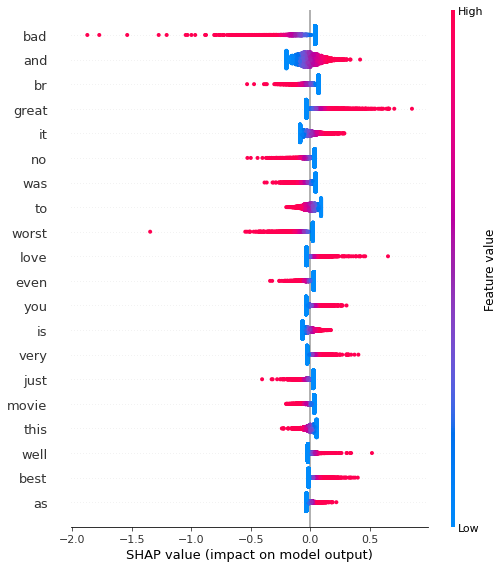

In [9]:
# Initialize JavaScript
shap.initjs()

# Visualize the explanations
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names())

### Explain the first review's sentiment prediction

Remember that higher means more likely to be negative, so in the plots below the "red" features are actually helping raise the chance of a positive review, while the negative features are lowering the chance. It is interesting to see how what is not present in the text (like bad=0 below) is often just as important as what is in the text. Remember the values of the features are TF-IDF values.

In [10]:
# Explaning the setiment of the data at index 0
shap.initjs()
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test[ind,:],
    feature_names=vectorizer.get_feature_names()
)

In [11]:
print("Positive" if y_test[ind] else "Negative", "Review:")
print(corpus_test[ind])

Negative Review:
b'This has got to be the most stupid film I have ever seen (spoilers ahead)! First of all, the plot is stupid. The little kid is weird and they move to a hotel because his father is the caretaker of it. We find that the kid has a gift, the "Shining". This gift never ever has anything to do with anything except to make the kid seem cool. Then the movie gets more boring and boring until the man finally goes crazy. He goes on a rampage to kill the kid and his wife because... well, he feels like it. Why else would he do it? All of a sudden we see a naked woman in the tub. The man kisses her and realizes he is kissing a dead corpse, which is utterly disgusting. Somehow a black man enters the hotel and is whacked with an axe. Then the kid and the woman take the black man\'s vehicle and leave the father, who dies within minutes of hypothermia. Most movies aren\'t a complete waste of time, but this falls right into that category. The music is trashy, the characters are corny (

### Explain the second review's sentiment prediction

In [12]:
# Explaning the setiment of the data at index 1
shap.initjs()
ind = 1
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test[ind,:],
    feature_names=vectorizer.get_feature_names()
)

In [13]:
print("Positive" if y_test[ind] else "Negative", "Review:")
print(corpus_test[ind])

Positive Review:
b'I never saw it on TV but rented the DVD through Netflix as soon as I found that it was available. I had high expectations, and was not disappointed. It\'s funny, and the animation is excellent. That level of quality I would only have expected from feature films, so I\'m surprised at some of the bad comments on it. Maybe the DVD release had improved animation? One bonus to the DVD is that it was fun to see both versions of the pilot. I\'m an adult, and I really appreciate that it is for adults. It isn\'t only kids who like cute animated characters. It is nowhere near "raunchy" as some have claimed, but I can see where some parents wouldn\'t want their young children to see it. I\'m very disappointed that it was cancelled. I wish they would produce more episodes. Or perhaps a movie.\n'


# Understanding Visualization

* Summary plot shows the positive and negative relationships of the predictors with the target variable. It looks dotty because it is made of all the instances in the train data. In this plot all the features are ranked in descending order that shows the importance of the features. The x-axis shows whether the effect of that value is associated with a higher or lower prediction. Red and blue colors shows the influence of the attribute (Red shows high infulence and blue shows less influence)

* Force plot shows features each contributing to push the model output from the base value to the model output. The base value id the average model output over the training dataset. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Force plots can show explanations of each instance or it can be used to plot exaplantion of all instances in the dataset to understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs the value of the feature for all the examples in a dataset.

* SHAP dependence plots shows the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples.



# Explore SHAP Package Documentation

In [14]:
help(shap.LinearExplainer)

Help on class Linear in module shap.explainers._linear:

class Linear(shap.explainers._explainer.Explainer)
 |  Computes SHAP values for a linear model, optionally accounting for inter-feature correlations.
 |  
 |  This computes the SHAP values for a linear model and can account for the correlations among
 |  the input features. Assuming features are independent leads to interventional SHAP values which
 |  for a linear model are coef[i] * (x[i] - X.mean(0)[i]) for the ith feature. If instead we account
 |  for correlations then we prevent any problems arising from colinearity and share credit among
 |  correlated features. Accounting for correlations can be computationally challenging, but
 |  LinearExplainer uses sampling to estimate a transform that can then be applied to explain
 |  any prediction of the model.
 |  
 |  Parameters
 |  ----------
 |  model : (coef, intercept) or sklearn.linear_model.*
 |      User supplied linear model either as either a parameter pair or sklearn o

# Coding Challenge:
- Implement the LIME explanation for the same prediction.
- For Logistic Regression, obtain the global feature importance.
- Compare the feature explanations given by LIME and SHAP.
- Experiment with changing the number of iterations for SHAP explanation.